In [3]:
# This script generates deep learning training data
# Author: Nikita Mishra
# run: python Deep_learning_training_data.py

# TODO: remove repeated solutions and change start and end position accordingly
import sys
import json
import pandas as pd
import numpy as np
import os
from pathlib import Path
from importlib.machinery import SourceFileLoader
import api_client
from api_client import *
import random
import math
from statistics import mean
from statistics import stdev
#api_client = SourceFileLoader("module.name", "../api_client.py").load_module()

DATA_DIR = 'data/'
SOLUTIONS_FILE = ''.join([DATA_DIR, 'solutions_org'])
QUERIES_FILE   = ''.join([DATA_DIR, 'queries_org'])
CAUCUSES_FILE  = ''.join([DATA_DIR, 'caucuses_org'])

MAX_OUTPUT = 1000000

MAX_LENGTH = 500
orgs_api = ApiClient('http://localhost:3002', '/v1/orgs')
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

def read(filename):
    print('Loading from file ', filename, '...')
    with open(filename) as data_file:
        return data_file.read().splitlines()
    
def read_padded(filename, MAX_LENGTH):
    print('Loading from file ', filename, '...')
    with open(filename) as data_file:
        data= data_file.read().splitlines()
        
    return [pad(item, MAX_LENGTH) for item in data ]

def pad(sentence,maxlength):
    LEN = len(sentence.split(' '))
    if LEN>=maxlength:
        return sentence[:maxlength]
    else:
        return ' '.join([sentence]+['BUFFER_PAD']*(maxlength-LEN))
    
def length_distribution( solutions_caucus):
    return [len(u.split(' ')) for u in solutions_caucus]


def print_dist(x):
    print('min:',min(x),'mean:',sum(x)/len(x),'max:',max(x))
    
# def mean(x):
#     return sum(x)/len(x)

# def stdev(x):
#     return (sum([item*item for item in x]) - mean(x)*mean(x))/len(x)
def classify(LOGITS_positive, LOGITS_negative):
    def print_dist(x):
        # Its a redefinition to make sure the dependencies are present for classify
        print('min:',min(x),'mean:',sum(x)/len(x),'max:',max(x))
        
    print('--Summary')
    print('Positive scores_distribution:')
    print_dist(LOGITS_positive)
    print('Negative scores_distribution:')
    print_dist(LOGITS_negative)
    
    left_point = min(LOGITS_positive+ LOGITS_negative)
    right_point = max(LOGITS_positive+ LOGITS_negative)
    errors=[]
    num_steps = 100
    gap = int(np.ceil(abs(left_point-right_point)/(num_steps - 1)))
    if gap <=0:
        print('Left should be smaller than right')
        print('Left:', left_point, ', Right:', right_point)
        return
    else:
        print('Left:', left_point, ', Right:', right_point)
    for threshold in np.arange(left_point, right_point, gap):
        error_positive = sum(i > threshold for i in LOGITS_positive) 
        error_negative = sum(i < threshold for i in LOGITS_negative) 
        error = error_positive + error_negative
        errors.append(error)
        #print(threshold, error, error_positive, error_negative)
    
    print('Num errors:', min(errors), ', Percent errors:',min(errors)/(len(LOGITS_negative)+len(LOGITS_positive)))
    return errors

In [4]:
queries = read_padded('/Users/nikita/nmt_data/Upwork/train/sources.tok', MAX_LENGTH)
solutions = read_padded('/Users/nikita/nmt_data/Upwork/train/targets.tok', MAX_LENGTH)
vocab_queries = read('/Users/nikita/nmt_data/Upwork/train/vocab.sources.tok')
vocab_solutions = read('/Users/nikita/nmt_data/Upwork/train/vocab.targets.tok')
vocab_queries_filtered = [row.split('\t')[0] for row in vocab_queries]
vocab_solutions_filtered = [row.split('\t')[0] for row in vocab_solutions]

# read caucus positive negative

queries_caucus_positive = read_padded('/Users/nikita/nmt_data/Upwork/caucus_positive/sources.tok',MAX_LENGTH)
solutions_caucus_positive = read_padded('/Users/nikita/nmt_data/Upwork/caucus_positive/targets.tok',MAX_LENGTH)
queries_caucus_negative = read_padded('/Users/nikita/nmt_data/Upwork/caucus_negative/sources.tok',MAX_LENGTH)
solutions_caucus_negative = read_padded('/Users/nikita/nmt_data/Upwork/caucus_negative/targets.tok',MAX_LENGTH)

# queries_caucus_positive = read('/Users/nikita/nmt_data/Upwork/caucus_positive/sources.tok')
# solutions_caucus_positive = read('/Users/nikita/nmt_data/Upwork/caucus_positive/targets.tok')
# queries_caucus_negative = read('/Users/nikita/nmt_data/Upwork/caucus_negative/sources.tok')
# solutions_caucus_negative = read('/Users/nikita/nmt_data/Upwork/caucus_negative/targets.tok')




Loading from file  /Users/nikita/nmt_data/Upwork/train/sources.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/train/targets.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/train/vocab.sources.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/train/vocab.targets.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/caucus_positive/sources.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/caucus_positive/targets.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/caucus_negative/sources.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/caucus_negative/targets.tok ...


In [4]:
coocurrence={}
for i, (query,solution) in  enumerate(zip(queries, solutions)):
    gen = ((x, y) for x in set(query.split(' ')) for y in set(solution.split(' ')))

    for u, v in gen:
        if (u,v) in coocurrence:
            coocurrence[(u,v)] = coocurrence[(u,v)] + 1
        else:
            coocurrence[(u,v)] = 1
    if i%1000 == 0:
        print('done with, i =', i)


done with, i = 0
done with, i = 1000
done with, i = 2000
done with, i = 3000
done with, i = 4000
done with, i = 5000
done with, i = 6000
done with, i = 7000
done with, i = 8000
done with, i = 9000
done with, i = 10000
done with, i = 11000
done with, i = 12000
done with, i = 13000
done with, i = 14000
done with, i = 15000
done with, i = 16000
done with, i = 17000
done with, i = 18000
done with, i = 19000
done with, i = 20000
done with, i = 21000
done with, i = 22000
done with, i = 23000
done with, i = 24000
done with, i = 25000
done with, i = 26000
done with, i = 27000
done with, i = 28000
done with, i = 29000
done with, i = 30000
done with, i = 31000
done with, i = 32000
done with, i = 33000
done with, i = 34000
done with, i = 35000
done with, i = 36000
done with, i = 37000
done with, i = 38000
done with, i = 39000
done with, i = 40000
done with, i = 41000
done with, i = 42000
done with, i = 43000
done with, i = 44000
done with, i = 45000
done with, i = 46000
done with, i = 47000
done 

In [7]:
max(coocurrence.values())



15242289334

In [8]:
ocurrenceX={}
for i, query in  enumerate(queries):
    for u in query.split(' '):
        if u in ocurrenceX:
            ocurrenceX[u] = ocurrenceX[u] + 1
        else:
            ocurrenceX[u] = 1
    if i%1000 == 0:
        print('done with, i =', i)


done with, i = 0
done with, i = 1000
done with, i = 2000
done with, i = 3000
done with, i = 4000
done with, i = 5000
done with, i = 6000
done with, i = 7000
done with, i = 8000
done with, i = 9000
done with, i = 10000
done with, i = 11000
done with, i = 12000
done with, i = 13000
done with, i = 14000
done with, i = 15000
done with, i = 16000
done with, i = 17000
done with, i = 18000
done with, i = 19000
done with, i = 20000
done with, i = 21000
done with, i = 22000
done with, i = 23000
done with, i = 24000
done with, i = 25000
done with, i = 26000
done with, i = 27000
done with, i = 28000
done with, i = 29000
done with, i = 30000
done with, i = 31000
done with, i = 32000
done with, i = 33000
done with, i = 34000
done with, i = 35000
done with, i = 36000
done with, i = 37000
done with, i = 38000
done with, i = 39000
done with, i = 40000
done with, i = 41000
done with, i = 42000
done with, i = 43000
done with, i = 44000
done with, i = 45000
done with, i = 46000
done with, i = 47000
done 

In [ ]:
print(len(coocurrence), len(ocurrenceX),len(queries))

In [28]:
import math

def likelihood(queries_caucus, solutions_caucus,coocurrence, ocurrenceX):
    a = sum(coocurrence.values())
    b = sum(ocurrenceX.values())
    neg_log_likelihood={}
    LOGITS = []
    for i, (query,solution) in  enumerate(zip(queries_caucus, solutions_caucus)):
        logits_num = 0
        gen = ((x, y) for x in query.split(' ') for y in solution.split(' '))
        for u, v in gen:
            if (u,v) in coocurrence:
                logits_num = logits_num + math.log(coocurrence[(u,v)]) - math.log(a)
        logits_den = 0
        for u in query.split(' '):
            if u in ocurrenceX:
                logits_den = logits_den + math.log(ocurrenceX[u]) - math.log(b)


        neg_log_likelihood[(query,solution)] = logits_num - logits_den
        LOGITS.append(neg_log_likelihood[(query,solution)])
        
    return neg_log_likelihood, LOGITS



In [36]:
neg_log_likelihood_positive, LOGITS_positive = likelihood(queries_caucus_positive, solutions_caucus_positive, coocurrence, ocurrenceX)
neg_log_likelihood_negative, LOGITS_negative = likelihood(queries_caucus_negative, solutions_caucus_negative, coocurrence, ocurrenceX)


In [20]:
LOGITS_positive

[-531415.4179733271,
 -541526.0021285274,
 -920512.1355407701,
 -306113.5094288111,
 -507181.49873869657,
 -347040.97657949314,
 -336159.1978995224,
 -350917.0826942429,
 -431960.1407557651,
 -353451.74391845556,
 -470346.77589999017,
 -430192.21594361204,
 -324716.7291003309,
 -327991.6115442466,
 -336975.3744686843,
 -624632.7793872658,
 -338113.48522266815,
 -554953.233953293,
 -303080.4656179927,
 -456055.039997381,
 -514590.7964943503,
 -603856.6844317077,
 -345100.4201860713,
 -366828.02532559726,
 -500175.46219489997,
 -775879.9451175975,
 -784900.6163077982,
 -419670.6320032354,
 -1490267.6048090218,
 -792271.3387556539,
 -285823.9790528625,
 -360856.25626493717,
 -553055.4876814713,
 -318450.6638183518,
 -558485.6776352812,
 -352354.28272130113,
 -385450.06088162074,
 -557590.7180151725,
 -377288.2211872898,
 -307826.2351987119,
 -476625.459085354,
 -524874.0774911062,
 -269852.6226952735,
 -466124.50062202325,
 -588774.3514636138,
 -817277.9330551795,
 -550356.7194103027,
 -1

In [ ]:
LOGITS_negative

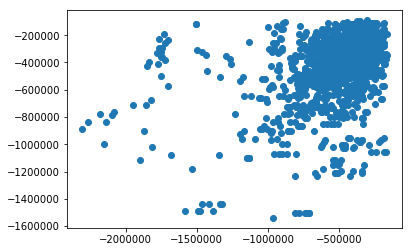

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(LOGITS_positive, LOGITS_negative) 

In [37]:
max_score = max(max(LOGITS_positive),max(LOGITS_negative))
min_score = min(min(LOGITS_positive),min(LOGITS_negative))

print('Positive:','min:',min(LOGITS_positive),'mean:',sum(LOGITS_positive)/len(LOGITS_positive),'max:',max(LOGITS_positive))
print('Negative:','min:',min(LOGITS_negative),'mean:',sum(LOGITS_negative)/len(LOGITS_negative),'max:',max(LOGITS_negative))
print(max_score, min_score)

Positive: min: -2302582.666602006 mean: -536970.5149132842 max: -165911.02687390576
Negative: min: -2139163.049362326 mean: -526841.6417576324 max: -127360.54354180142
-127360.54354180142 -2302582.666602006


In [38]:
import numpy as np
errors=[]
for threshold in np.arange(-1036720, -28, 1000):
    error_positive = sum(i > threshold for i in LOGITS_positive) 
    error_negative = sum(i < threshold for i in LOGITS_negative) 
    error = error_positive + error_negative
    errors.append(error)
    print(threshold, error, error_positive, error_negative)

-1036720 1412 1311 101
-1035720 1413 1311 102
-1034720 1414 1311 103
-1033720 1414 1311 103
-1032720 1414 1311 103
-1031720 1415 1311 104
-1030720 1415 1311 104
-1029720 1415 1311 104
-1028720 1414 1310 104
-1027720 1414 1310 104
-1026720 1414 1310 104
-1025720 1414 1310 104
-1024720 1414 1310 104
-1023720 1414 1310 104
-1022720 1415 1309 106
-1021720 1415 1309 106
-1020720 1415 1309 106
-1019720 1415 1309 106
-1018720 1415 1309 106
-1017720 1415 1309 106
-1016720 1415 1309 106
-1015720 1417 1309 108
-1014720 1416 1307 109
-1013720 1415 1306 109
-1012720 1415 1306 109
-1011720 1415 1306 109
-1010720 1416 1306 110
-1009720 1415 1305 110
-1008720 1415 1305 110
-1007720 1416 1305 111
-1006720 1416 1305 111
-1005720 1416 1305 111
-1004720 1416 1305 111
-1003720 1416 1305 111
-1002720 1415 1304 111
-1001720 1415 1304 111
-1000720 1415 1304 111
-999720 1416 1304 112
-998720 1416 1303 113
-997720 1416 1303 113
-996720 1416 1303 113
-995720 1416 1303 113
-994720 1415 1302 113
-993720 1415 1302

-544720 1322 857 465
-543720 1320 852 468
-542720 1321 852 469
-541720 1321 850 471
-540720 1321 847 474
-539720 1323 845 478
-538720 1326 845 481
-537720 1323 841 482
-536720 1321 838 483
-535720 1321 836 485
-534720 1319 833 486
-533720 1316 829 487
-532720 1317 828 489
-531720 1319 827 492
-530720 1321 825 496
-529720 1320 821 499
-528720 1321 821 500
-527720 1322 818 504
-526720 1319 814 505
-525720 1318 810 508
-524720 1317 808 509
-523720 1315 805 510
-522720 1312 802 510
-521720 1313 799 514
-520720 1313 796 517
-519720 1312 793 519
-518720 1311 790 521
-517720 1310 788 522
-516720 1311 787 524
-515720 1311 786 525
-514720 1314 785 529
-513720 1313 781 532
-512720 1313 781 532
-511720 1312 779 533
-510720 1312 778 534
-509720 1311 776 535
-508720 1310 771 539
-507720 1312 770 542
-506720 1310 767 543
-505720 1311 766 545
-504720 1310 765 545
-503720 1310 763 547
-502720 1312 762 550
-501720 1310 759 551
-500720 1312 757 555
-499720 1310 755 555
-498720 1307 750 557
-497720 1304 

In [42]:
length_positive = length_distribution(solutions_caucus_positive)
length_negative = length_distribution(solutions_caucus_negative)
print('positive')
print_dist(length_positive)
print('negative')
print_dist(length_negative)
print('Num errors:', min(errors), ', Percent errors:',min(errors)/(len(LOGITS_negative)+len(LOGITS_positive)))

positive
min: 500 mean: 500.0 max: 500
negative
min: 92 mean: 499.70477568740955 max: 500
Num errors: 1297 , Percent errors: 0.469247467438


# Bi-gram

In [6]:
def bigrams_list(text):
    return [b for l in text for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]

def bigrams(text):
    return [list(zip(l.split(" ")[:-1], l.split(" ")[1:])) for l in text]

In [7]:
# download
queries_caucus_positive = read('/Users/nikita/nmt_data/Upwork/caucus_positive/sources.tok')
solutions_caucus_positive = read('/Users/nikita/nmt_data/Upwork/caucus_positive/targets.tok')
queries_caucus_negative = read('/Users/nikita/nmt_data/Upwork/caucus_negative/sources.tok')
solutions_caucus_negative = read('/Users/nikita/nmt_data/Upwork/caucus_negative/targets.tok')
queries = read('/Users/nikita/nmt_data/Upwork/train/sources.tok')
solutions = read('/Users/nikita/nmt_data/Upwork/train/targets.tok')

Loading from file  /Users/nikita/nmt_data/Upwork/caucus_positive/sources.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/caucus_positive/targets.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/caucus_negative/sources.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/caucus_negative/targets.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/train/sources.tok ...
Loading from file  /Users/nikita/nmt_data/Upwork/train/targets.tok ...


In [8]:
# Create vocabulary
vocab = set(bigrams_list(queries_caucus_positive) + \
            bigrams_list(solutions_caucus_positive) + \
            bigrams_list(solutions_caucus_negative) + \
            bigrams_list(queries) + \
            bigrams_list(solutions)
           )
print('Vocab length:',len(vocab))

Vocab length: 1013512


In [ ]:
queries_bigram = bigrams(queries)
solutions_bigram = bigrams(solutions)
queries_caucus_negative_bigram = bigrams(queries_caucus_negative)
queries_caucus_positive_bigram = bigrams(queries_caucus_positive)
solutions_caucus_positive_bigram = bigrams(solutions_caucus_positive)
solutions_caucus_negative_bigram = bigrams(solutions_caucus_negative)


In [ ]:
import time
start_time = time.time()
coocurrence_bigram={}
for i, (query,solution) in  enumerate(zip(queries_bigram, solutions_bigram)):
    gen = ((x, y) for x in set(query) for y in set(solution))

    for u, v in gen:
        if (u,v) in coocurrence_bigram:
            coocurrence_bigram[(u,v)] = coocurrence_bigram[(u,v)] + 1
        else:
            coocurrence_bigram[(u,v)] = 1
    if i%1000 == 0:
        print('done with, i =', i,'in', time.time() - start_time,'seconds')
    



done with, i = 0 in 0.005647182464599609 seconds
done with, i = 1000 in 4.63471794128418 seconds
done with, i = 2000 in 10.328782081604004 seconds
done with, i = 3000 in 16.832261085510254 seconds
done with, i = 4000 in 22.25088095664978 seconds
done with, i = 5000 in 28.33743715286255 seconds
done with, i = 6000 in 34.662161111831665 seconds
done with, i = 7000 in 43.64556121826172 seconds
done with, i = 8000 in 49.76537799835205 seconds
done with, i = 9000 in 56.48021912574768 seconds
done with, i = 10000 in 63.19908022880554 seconds
done with, i = 11000 in 70.32285809516907 seconds
done with, i = 12000 in 77.65740609169006 seconds
done with, i = 13000 in 85.56477808952332 seconds
done with, i = 14000 in 93.91166520118713 seconds
done with, i = 15000 in 113.47984910011292 seconds
done with, i = 16000 in 124.74603796005249 seconds
done with, i = 17000 in 137.23000407218933 seconds
done with, i = 18000 in 153.00731420516968 seconds
done with, i = 19000 in 171.10409021377563 seconds
don

In [7]:
ocurrenceX={}
for i, query in  enumerate(queries):
    for u in set(query.split(' ')):
        if u in ocurrenceX:
            ocurrenceX[u] = ocurrenceX[u] + 1
        else:
            ocurrenceX[u] = 1
    if i%1000 == 0:
        print('done with, i =', i)

done with, i = 0
done with, i = 1000
done with, i = 2000
done with, i = 3000
done with, i = 4000
done with, i = 5000
done with, i = 6000
done with, i = 7000
done with, i = 8000
done with, i = 9000
done with, i = 10000
done with, i = 11000
done with, i = 12000
done with, i = 13000
done with, i = 14000
done with, i = 15000
done with, i = 16000
done with, i = 17000
done with, i = 18000
done with, i = 19000
done with, i = 20000
done with, i = 21000
done with, i = 22000
done with, i = 23000
done with, i = 24000
done with, i = 25000
done with, i = 26000
done with, i = 27000
done with, i = 28000
done with, i = 29000
done with, i = 30000
done with, i = 31000
done with, i = 32000
done with, i = 33000
done with, i = 34000
done with, i = 35000
done with, i = 36000
done with, i = 37000
done with, i = 38000
done with, i = 39000
done with, i = 40000
done with, i = 41000
done with, i = 42000
done with, i = 43000
done with, i = 44000
done with, i = 45000
done with, i = 46000
done with, i = 47000
done 

In [13]:
import math

def likelihood(queries_caucus, solutions_caucus,coocurrence, ocurrenceX):
    a = sum(coocurrence.values())
    b = sum(ocurrenceX.values())
    neg_log_likelihood={}
    LOGITS = []
    for i, (query,solution) in  enumerate(zip(queries_caucus, solutions_caucus)):
        logits_num = 0
        gen = ((x, y) for x in query for y in solution)
        for u, v in gen:
            if (u,v) in coocurrence:
                logits_num = logits_num + math.log(coocurrence[(u,v)]) - math.log(a)
        logits_den = 0
        for u in query:
            if u in ocurrenceX:
                logits_den = logits_den + math.log(ocurrenceX[u]) - math.log(b)


        #neg_log_likelihood[(query,solution)] = logits_num - logits_den
        LOGITS.append(logits_num - logits_den)
        
    return  LOGITS



In [14]:
LOGITS_positive = likelihood(queries_caucus_positive_bigram, solutions_caucus_positive_bigram, coocurrence_bigram, ocurrenceX)
LOGITS_negative = likelihood(queries_caucus_negative_bigram, solutions_caucus_negative_bigram, coocurrence_bigram, ocurrenceX)


In [18]:
LOGITS_negative

[-13734.364374788027,
 -8984.203123492112,
 -35687.5927635928,
 -18235.717626624206,
 -27896.340056447632,
 -5170.774180155202,
 -316.29220694065714,
 -12824.238631450256,
 -23044.418301670194,
 -13025.378675146298,
 -5330.780926625951,
 -7976.54110303193,
 -3730.2422438687972,
 -1733.6293339544036,
 -1229.9985966367583,
 -5962.66831106352,
 -11151.639339339763,
 -13110.285538391126,
 -3389.129746402625,
 -34180.938545879195,
 -4508.466522830417,
 -13268.112918146058,
 -3878.7710543643557,
 -57.85874861122703,
 -27543.513643338392,
 -16252.125386881566,
 -7267.110389584571,
 -5020.865915411114,
 -109722.38899577808,
 -28955.578616913892,
 -2539.5759859304635,
 -10888.347817141857,
 -44228.83809900776,
 -1259.1973731785959,
 -18614.461652761904,
 -882.1800581205018,
 -2887.4479307930865,
 -29759.111798965023,
 -5236.260820211467,
 -58.551895791786976,
 -35948.4971036429,
 -6589.098366763942,
 -26430.538939015856,
 -110671.9684881579,
 -8761.966219510277,
 -26372.488837557397,
 -15370.49

In [40]:
errors = classify(LOGITS_positive, LOGITS_negative)

--Summary
Positive scores_distribution:
min: -370587.14361465344 mean: -18844.206193395054 max: 0
Negative scores_distribution:
min: -324539.5913226043 mean: -14128.902639402299 max: 0
Left: -370587.14361465344 , Right: 0
Num errors: 1227 , Percent errors: 0.443921852388


In [41]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde


def plot_density(data):
    left_point, right_point = min(data), max(data)   
    num_steps = 100
    gap = int(np.ceil(abs(left_point-right_point)/(num_steps - 1)))    
    density = gaussian_kde(data)
    xs = np.arange(left_point, right_point, gap)
    plt.plot(xs,density(xs))
    plt.show()

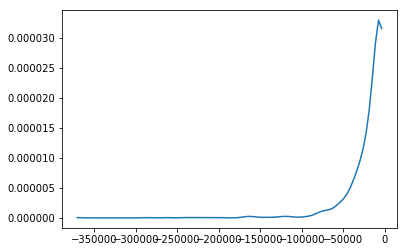

In [42]:
plot_density(LOGITS_positive)

In [74]:
# Bagging
from joblib import Parallel, delayed
import multiprocessing

def classify_sample(LOGITS_positive, LOGITS_negative):    
        ids = random.sample(range(len(LOGITS_positive)),  math.ceil(len(LOGITS_positive)*0.7) ) 
        LOGITS_positive = [LOGITS_positive[item] for item in ids ]
        LOGITS_negative = [LOGITS_negative[item] for item in ids ]

        left_point = min(LOGITS_positive+ LOGITS_negative)
        right_point = max(LOGITS_positive+ LOGITS_negative)
        errors=[]
        num_steps = 100
        gap = int(np.ceil(abs(left_point-right_point)/(num_steps - 1)))
        if gap <=0:
            print('Left should be smaller than right')
            print('Left:', left_point, ', Right:', right_point)
            return
        for threshold in np.arange(left_point, right_point, gap):
            error_positive = sum(i > threshold for i in LOGITS_positive) 
            error_negative = sum(i < threshold for i in LOGITS_negative) 
            error = error_positive + error_negative
            errors.append(error)
            #print(threshold, error, error_positive, error_negative)
        return min(errors)/(len(LOGITS_negative)+len(LOGITS_positive))
def classify_bagged(LOGITS_positive, LOGITS_negative):
    
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(classify_sample)(LOGITS_positive, LOGITS_negative) for i in range(10))
    print(mean(results),stdev(results))

In [75]:
classify_bagged(LOGITS_positive, LOGITS_negative)

0.442510330579 0.003156513481495496


# Interesting co-occuring words

In [2]:
len(coocurrence_bigram)

NameError: name 'coocurrence_bigram' is not defined

In [1]:
A = coocurrence_bigram
newA = dict(sorted(A.items(), key=operator.itemgetter(1), reverse=True)[:5])

NameError: name 'coocurrence_bigram' is not defined

In [ ]:
names = coocurrence_bigram
sorted_names = sorted(names.items(), key=lambda (k, v): (-v, k))[:10]